In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

In [2]:
import plots_setup

# Use the function to set up the style of graphs
plots_setup.setup_style()

In [3]:
# Load a webscrapped dataset
eurlex_scrapped = pd.read_csv('../Data/eurlex-data-scrapped.csv')

In [4]:
# check out the most common types of legislation
common_forms = eurlex_scrapped['Form'].value_counts().head(50)

#common_forms

In [5]:
eurlex_scrapped = eurlex_scrapped.dropna(subset=['CELEX']).reset_index(drop=True)

Filtering types

In [6]:
# Convert the result to a list
# Filter the 'Form' column for values containing "proposal" or "draft",
# and exclude "Proposal for an implementing decision"
filtered_forms = eurlex_scrapped['Form'][eurlex_scrapped['Form'].str.contains(r'proposal|draft', case=False, na=False)]
filtered_forms = filtered_forms[~filtered_forms.str.contains(r'implementing decision', case=False)]
filtered_forms = filtered_forms[~filtered_forms.str.contains(r'amend', case=False)]

# Convert the result to a list
proposals_types = filtered_forms.unique().tolist()

# Print the list of values
print(proposals_types)


['Proposal for a decision', 'Proposal for a regulation', 'Proposal for a directive', 'Proposal for a decision without addressee', 'Proposal for an act', 'Proposal for a recommendation', 'Draft regulation', 'Draft decision']


In [7]:
# Filter the dataframe to keep proposals
proposals = eurlex_scrapped[eurlex_scrapped['Form'].isin(proposals_types)]

In [8]:
# Filter out rows with the title "This document does not exist in English."
# and rows containing the word "Vorschlag"
proposals = proposals[
    ~proposals['Title'].str.contains(r'^This document does not exist in English\.$', case=False, na=False) &
    ~proposals['Title'].str.contains(r'Vorschlag', case=False, na=False)
]


In [9]:
# Extract the year from the CELEX column
proposals['Year'] = proposals['CELEX'].str[1:5].astype(int)

# Filter rows for which the year is between 2000 and 2023 inclusive
proposals = proposals[(proposals['Year'] >= 2000) & (proposals['Year'] <= 2023)]

proposals = proposals.drop(columns=['Pages'])


Check duplicates in titles

In [10]:
 # Check for duplicated titles
duplicated_titles = proposals[proposals.duplicated(subset=['Title'], keep=False)]

# Create a DataFrame containing only the CELEX numbers and the titles of duplicated entries
duplicated_celex_df = duplicated_titles[['CELEX', 'Title']]

# Display the DataFrame
print(duplicated_celex_df)

                CELEX                                              Title
104   52023PC0533(01)  Proposal for a REGULATION OF THE EUROPEAN PARL...
105       52023PC0533  Proposal for a REGULATION OF THE EUROPEAN PARL...
148       52023PC0402  Proposal for a REGULATION OF THE EUROPEAN PARL...
165       52023PC0420  Proposal for a DIRECTIVE OF THE EUROPEAN PARLI...
199       52023PC0271  Proposal for a DIRECTIVE OF THE EUROPEAN PARLI...
...               ...                                                ...
5209      52000PC0487  Proposal for a Directive of the European Parli...
5293      52000PC0186  Proposal for a Regulation of the European Parl...
5305      52000PC0121  Proposal for a Regulation of the European Parl...
5336      52000PC0030  Proposal for a Regulation of the European Parl...
5338      52000PC0042  Proposal for a Directive of the European Parli...

[69 rows x 2 columns]


In [11]:
# Filter out rows with sequential numbers
pattern = r'\(\d+\)$'
duplicated_celex_with_digits = duplicated_titles[duplicated_titles['CELEX'].str.contains(pattern)]

# Drop those entries from the original proposals DataFrame
proposals = proposals[~proposals['CELEX'].isin(duplicated_celex_with_digits['CELEX'])]


In [12]:
# check out the most common types of legislation
common_forms = proposals['Form'].value_counts().head(50)

common_forms

Proposal for a regulation                    1373
Proposal for a directive                      725
Proposal for a decision                       148
Proposal for a decision without addressee      92
Proposal for a recommendation                  14
Draft decision                                  2
Proposal for an act                             1
Draft regulation                                1
Name: Form, dtype: int64

Analysis

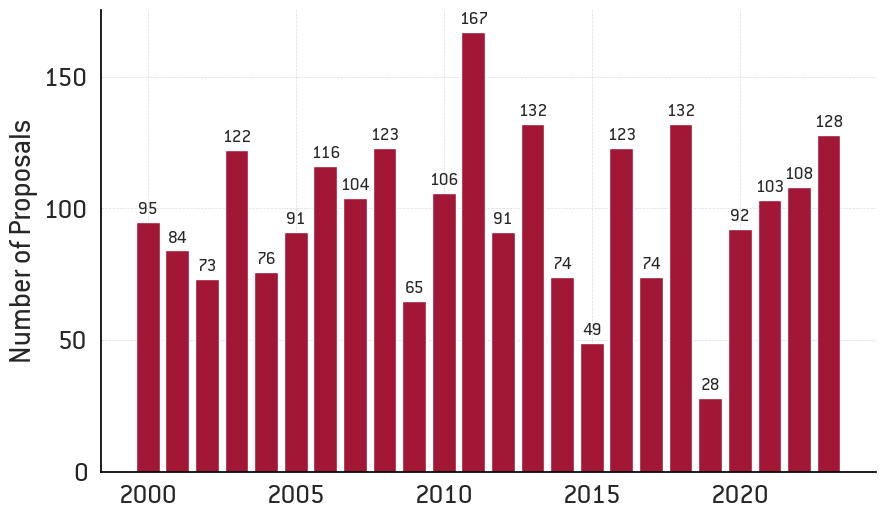

In [13]:
# Calculate the sum of rows for each year
yearly_proposals = proposals['Year'].value_counts().sort_index()

# Create a bar chart with value annotations
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_proposals.index, yearly_proposals.values)

# Add value annotations to each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize = 14)

plt.xlabel('')
plt.ylabel('Number of Proposals')
plt.title('')
plt.xticks()
plt.show()

In [14]:
# Categorize proposals based on year
proposals['Commission'] = pd.cut(
    proposals['Year'].astype(int),
    bins=[1999, 2004, 2009, 2013, 2018, 2023],
    labels=['Prodi', 'Barroso I', 'Barroso II', 'Juncker', 'Von der Leyen I'],
    right=True,
    include_lowest=True
)

# Add 'Election Year' as a category to the 'Commission' column
proposals['Commission'] = proposals['Commission'].cat.add_categories(['Election Year'])

# Set 2004, 2009, 2014, 2019, and 2024 as 'Election Year'
proposals.loc[proposals['Year'].isin([2004, 2009, 2014, 2019, 2024]), 'Commission'] = 'Election Year'

# Calculate the Year_in_Commission
proposals['Year_in_Commission'] = proposals.apply(
    lambda row: row['Year'] - { 
        'Prodi': 1999, 
        'Barroso I': 2004, 
        'Barroso II': 2009, 
        'Juncker': 2014, 
        'Von der Leyen I': 2019 
    }.get(row['Commission'], pd.NA),
    axis=1
)


In [15]:
# Create a version of proposals without election years
proposals_no_el = proposals[proposals['Commission'] != 'Election Year']

# Reset the index if needed
proposals_no_el = proposals_no_el.reset_index(drop=True)

# Calculate the sum of rows for each year in commission and each commission
proposal_counts = proposals_no_el.groupby(['Commission', 'Year_in_Commission']).size().reset_index(name='Count')


In [16]:
proposal_counts.head()

,Commission,Year_in_Commission,Count
0,Prodi,1,95
1,Prodi,2,84
2,Prodi,3,73
3,Prodi,4,122
4,Barroso I,1,91


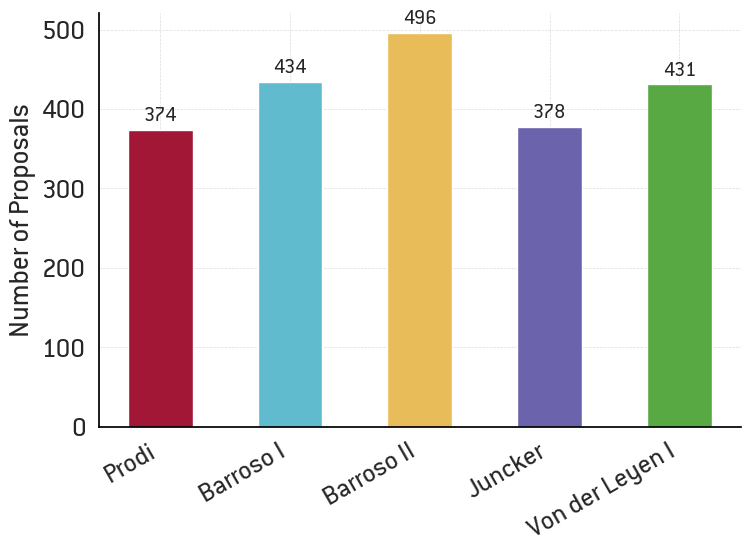

        Commission Year_in_Commission Count
0            Prodi              Total   374
1        Barroso I              Total   434
2       Barroso II              Total   496
3          Juncker              Total   378
4  Von der Leyen I              Total   431


In [17]:
# After calculating proposal_counts, create a new DataFrame for the total counts for each commission
total_counts_df = pd.DataFrame(columns=['Commission', 'Year_in_Commission', 'Count'])

# First plot: Total Number of Proposals
fig1, ax2 = plt.subplots(figsize=(8, 6))  # Create separate figure for the total graph

commissions = ['Prodi', 'Barroso I', 'Barroso II', 'Juncker', 'Von der Leyen I']

for i, commission in enumerate(commissions):
    subset = proposal_counts[proposal_counts['Commission'] == commission]
    
    # Calculate the total proposals for this commission
    total_count = subset['Count'].sum()
    
    # Add the total to the dataset for plotting and to total_counts_df using pd.concat
    subset = pd.concat([subset, pd.DataFrame([{
        'Year_in_Commission': 'Total', 
        'Commission': commission, 
        'Count': total_count
    }])], ignore_index=True)
    
    total_counts_df = pd.concat([total_counts_df, pd.DataFrame([{
        'Year_in_Commission': 'Total', 
        'Commission': commission, 
        'Count': total_count
    }])], ignore_index=True)
    
    # Plot the bar for Total on the first axis (ax2)
    total_height = subset[subset['Year_in_Commission'] == 'Total']['Count'].iloc[0]
    ax2.bar(commission, total_height, width=0.5, label=commission)  # Adjusted bar width for narrower plot
    
    # Add value annotations to the bar plot
    ax2.annotate(f'{total_height}', 
                 xy=(i, total_height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=16)

# Customize the first plot (Total on ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Number of Proposals', fontsize=22)
ax2.set_title('', pad=15)
ax2.set_ylim(0, None)

# Rotate x-axis labels for the first plot (ax2)
plt.setp(ax2.get_xticklabels(), rotation=30, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Save total_counts_df to Excel
print(total_counts_df.head())  # Print the head of the dataset for verification
total_counts_df.to_excel('../Data/Figure1_data.xlsx', index=False)


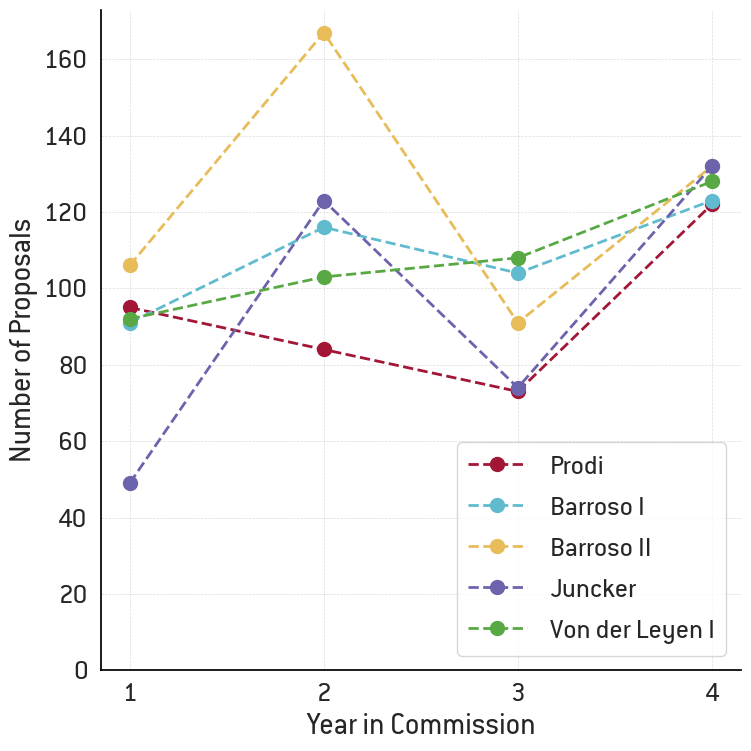

In [18]:
# Second plot: Proposals by Year
fig2, ax1 = plt.subplots(figsize=(8, 8))  # Create separate figure for the trend graph

years_in_commission = sorted(proposal_counts['Year_in_Commission'].unique())

for commission in commissions:
    subset = proposal_counts[proposal_counts['Commission'] == commission]
    
    # Plot lines with big dots for years 1-4 on the second axis (ax1)
    positions = [year for year in subset['Year_in_Commission'] if year != 'Total']
    counts = subset[subset['Year_in_Commission'] != 'Total']['Count'].tolist()
    
    ax1.plot(positions, counts, 
             marker='o', 
             linestyle='--',  # Dashed line
             markersize=10,    # Big dots
             linewidth=2, 
             label=f'{commission}')

# Customize the second plot (years 1-4 on ax1)
ax1.set_xlabel('Year in Commission')
ax1.set_ylabel('Number of Proposals')
ax1.set_title('')
ax1.legend(loc='lower right')
ax1.set_ylim(0, None)

# Ensure the x-axis displays years as integers
ax1.set_xticks(range(1, 5))
ax1.set_xticklabels(range(1, 5))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [19]:
# Create a dummy variable for the presence of the word 'repeal' in the Title
proposals['Repeal_Dummy'] = proposals['Title'].str.contains(r'\brepeal\w*\b', case=False, na=False).astype(int)


In [20]:
# Define a function to count the number of repeals in a title
def count_repeals(title, repeal_dummy, celex):
    if repeal_dummy == 0:
        return 0
    
    # Check for the specific phrase "repeal of certain"
    if re.search(r'repeal of certain', title.lower()):
        print(f"Manual review required for title CELEX: {celex}")
        return np.nan  # Return NaN for manual review
    
    # Find the part after "repealing" and before any occurrence of "amending" or other similar phrases
    match = re.search(r'repealing (.+?)(?: and amending|, amending| amending|$)', title.lower())
    
    if match:
        repealing_part = match.group(1)
        
        # Match various formats of references to legal acts
        acts = re.findall(r'(no \d+/\d+|\(eu\) no \d+/\d+|\d+/\d+|directives? \d+/\d+)', repealing_part)
        
        if acts:
            return len(acts)
        else:
            print(f"Manual review required for  CELEX: {celex}")
            return 1  # Fallback: if "repealing" is present but no acts are matched, return 1
    else:
        print(f"Manual review required for CELEX: {celex}")
        return 1  # Fallback: if "repealing" is not properly matched, return 1

# Apply the function to each row in the DataFrame
proposals['Repeal_Count'] = proposals.apply(lambda row: count_repeals(row['Title'], row['Repeal_Dummy'], row['CELEX']), axis=1)

# Display the updated DataFrame
result = proposals[['Title', 'Repeal_Dummy', 'Repeal_Count', 'CELEX']]

Manual review required for  CELEX: 52021PC0776
Manual review required for  CELEX: 52017PC0114
Manual review required for  CELEX: 52014PC0713
Manual review required for  CELEX: 52014PC0715
Manual review required for  CELEX: 52014PC0714
Manual review required for title CELEX: 52013PC0680
Manual review required for title CELEX: 52012PC0217
Manual review required for  CELEX: 52010PC0765
Manual review required for  CELEX: 52010PC0764
Manual review required for  CELEX: 52000PC0438(05)


In [21]:

# Dictionary to map CELEX codes to their corresponding Repeal_Count values
manual_recode = {
    "52021PC0776": 11,
    "52017PC0114": 10,
    "52013PC0680": 0,  # Also update Repeal_Dummy to 0
    "52012PC0217": 0,  # Also update Repeal_Dummy to 0
    "52010PC0765": 21,
    "52010PC0764": 6,
    "52000PC0438(05)": 17
}

# Apply the manual recoding based on CELEX
for celex, repeal_count in manual_recode.items():
    proposals.loc[proposals['CELEX'] == celex, 'Repeal_Count'] = repeal_count
    
    # Update the Repeal_Dummy to 0 where specified
    if repeal_count == 0:
        proposals.loc[proposals['CELEX'] == celex, 'Repeal_Dummy'] = 0


In [22]:

# Group by Commission and calculate the required statistics
repealing_acts_per_commission = proposals.groupby('Commission')['Repeal_Dummy'].sum()
total_repeals_per_commission = proposals.groupby('Commission')['Repeal_Count'].sum()

# Combine the two statistics into one DataFrame for easier plotting
combined_data = pd.DataFrame({
    'Number of Repealing Acts': repealing_acts_per_commission,
    'Total Number of Repeals': total_repeals_per_commission
})

combined_data = combined_data.loc[combined_data.index != 'Election Year']


                 Number of Repealing Acts  Total Number of Repeals
Commission                                                        
Prodi                                   4                     21.0
Barroso I                              19                     26.0
Barroso II                             42                     82.0
Juncker                                62                    108.0
Von der Leyen I                        53                     91.0


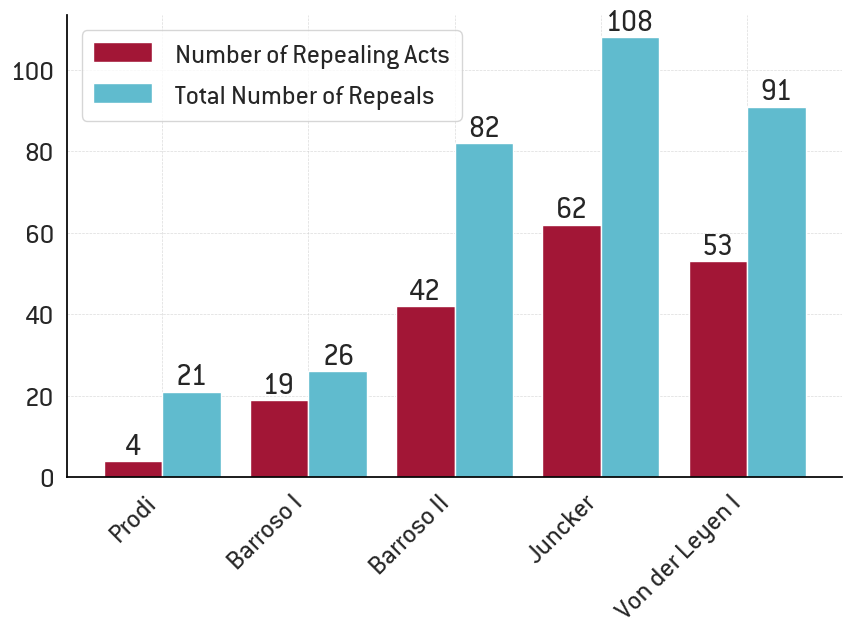

In [23]:
print(combined_data.head())  # Print the head of the dataset for verification
combined_data.to_excel('../Data/Figure3_data.xlsx', index=True)

# Plotting on a single axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot
bars = combined_data.plot(kind='bar', ax=ax, width=0.8)

# Adding labels to each bar
for bar in bars.patches:
    bar_value = bar.get_height()
    bar_label = int(bar_value)  # Convert to integer for labeling

    # Position the label above the bar
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position: center of the bar
        bar_value,  # Y position: top of the bar
        bar_label,  # The label text
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Rotate the x-axis labels (Commission names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Set the axis labels and title
ax.set_xlabel('')


plt.show()


In [24]:
# Define the periods
periods = {
    'Prodi': (2000, 2003),
    'Barroso I': (2005, 2008),
    'Barroso II': (2010, 2013),
    'Juncker': (2015, 2018),
    'von der Leyen I': (2020, 2023)
}

# Define a function to categorize each proposal based on its title
def categorize_proposal(title):
    # Combine 'recast' and 'codification' into a single category called 'Simplification'
    if 'amend' in title.lower() and not any(x in title.lower() for x in ['recast', 'codify', 'codification']):
        return 'Amendment'
    elif any(x in title.lower() for x in ['recast', 'codify', 'codification']):
        return 'Simplification'
    else:
        return 'New Legislation'

# Apply the categorization function to each row in the proposals DataFrame
proposals['Category'] = proposals['Title'].apply(categorize_proposal)

# Initialize dictionaries to store the absolute counts and shares
category_counts_absolute = {}
category_counts_shares = {}

# Calculate counts and shares for each period and each category
for period, (start_year, end_year) in periods.items():
    # Filter data for the specific period
    period_data = proposals[(proposals['Year'] >= start_year) & (proposals['Year'] <= end_year)]
    
    # Calculate the total number of proposals for the period
    total_proposals = period_data.shape[0]
    
    # Count the occurrences for each category using value_counts
    category_counts = period_data['Category'].value_counts()
    
    # Store the absolute counts
    category_counts_absolute[period] = category_counts.to_dict()
    
    # Store the shares
    category_counts_shares[period] = (category_counts / total_proposals).to_dict()

# Convert the dictionaries into DataFrames for better visualization
category_counts_absolute_df = pd.DataFrame(category_counts_absolute).T.fillna(0)
category_counts_shares_df = pd.DataFrame(category_counts_shares).T.fillna(0)

# Display the DataFrames
print("Absolute Counts DataFrame:")
print(category_counts_absolute_df)

print("\nShares DataFrame:")
print(category_counts_shares_df)


Absolute Counts DataFrame:
                 New Legislation  Amendment  Simplification
Prodi                        215        155               4
Barroso I                    224        178              32
Barroso II                   276        204              16
Juncker                      163        185              30
von der Leyen I              152        254              25

Shares DataFrame:
                 New Legislation  Amendment  Simplification
Prodi                   0.574866   0.414439        0.010695
Barroso I               0.516129   0.410138        0.073733
Barroso II              0.556452   0.411290        0.032258
Juncker                 0.431217   0.489418        0.079365
von der Leyen I         0.352668   0.589327        0.058005


In [35]:
# Define a function to specifically count recasts and codifications
def count_recasts_codifications(title):
    if 'recast' in title.lower():
        return 'Recast'
    elif 'codify' in title.lower() or 'codification' in title.lower():
        return 'Codification'
    else:
        return None

# Apply the function to categorize recasts and codifications
proposals['Recast_Codification'] = proposals['Title'].apply(count_recasts_codifications)

# Initialize dictionaries to store recasts and codifications counts
recast_codification_counts_absolute = {}
recast_codification_counts_shares = {}

# Calculate counts and shares for each period for recasts and codifications
for period, (start_year, end_year) in periods.items():
    # Filter data for the specific period
    period_data = proposals[(proposals['Year'] >= start_year) & (proposals['Year'] <= end_year)]
    
    # Calculate the total number of proposals for the period
    total_proposals = period_data.shape[0]
    
    # Count the occurrences of recasts and codifications
    recast_codification_counts = period_data['Recast_Codification'].value_counts()
    
    # Store the absolute counts
    recast_codification_counts_absolute[period] = recast_codification_counts.to_dict()
    
    # Store the shares
    recast_codification_counts_shares[period] = (recast_codification_counts / total_proposals).to_dict()

# Convert the dictionaries into DataFrames for better visualization
recast_codification_counts_absolute_df = pd.DataFrame(recast_codification_counts_absolute).T.fillna(0)
recast_codification_counts_shares_df = pd.DataFrame(recast_codification_counts_shares).T.fillna(0)

# Display the DataFrames for recasts and codifications
print("Recast and Codification Absolute Counts DataFrame:")
print(recast_codification_counts_absolute_df)

print("\nRecast and Codification Shares DataFrame:")
print(recast_codification_counts_shares_df)


Recast and Codification Absolute Counts DataFrame:
                 Recast  Codification
Prodi               4.0           0.0
Barroso I          32.0           0.0
Barroso II         14.0           2.0
Juncker            22.0           8.0
von der Leyen I    17.0           8.0

Recast and Codification Shares DataFrame:
                   Recast  Codification
Prodi            0.010695      0.000000
Barroso I        0.073733      0.000000
Barroso II       0.028226      0.004032
Juncker          0.058201      0.021164
von der Leyen I  0.039443      0.018561


In [25]:
# Save the DataFrame to a CSV file in the ../Data directory
proposals.to_csv('../Data/proposals_processed.csv', index=False)

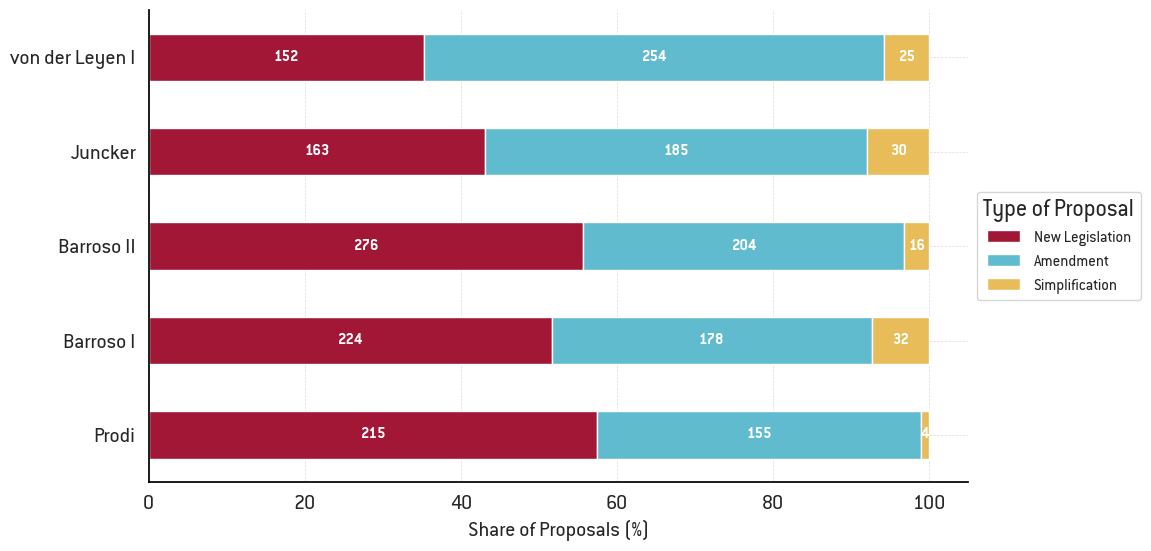

In [26]:
category_counts_shares_df.to_excel('../Data/Figure4a_shares_data.xlsx', index=True)
category_counts_absolute_df.to_excel('../Data/Figure4b_absolute_data.xlsx', index=True)

# Plot the data as a stacked horizontal bar chart with shares
ax = category_counts_shares_df.plot(kind='barh', stacked=True, figsize=(12, 6))

# Customize the plot
plt.ylabel('')
plt.xlabel('Share of Proposals (%)', fontsize=16)
plt.title('')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}'))

# Annotate the bars with absolute numbers
for i, container in enumerate(ax.containers):
    for rect in container:
        width = rect.get_width()
        y = rect.get_y() + rect.get_height() / 2
        period = category_counts_shares_df.index[int(y)]
        category = category_counts_shares_df.columns[i]
        absolute_value = category_counts_absolute_df.loc[period, category]
        
        # Example for special cases like Barroso II and Codifications, now under "Simplification"
        if absolute_value == 4 and category == 'Simplification' and period == 'Prodi (2000-2003)':
            ax.text(rect.get_x() + width + 0.025, y, f'{absolute_value}', ha='left', va='center', color='white', fontsize=12, weight='bold')
            plt.annotate('', xy=(rect.get_x() + width, y), xytext=(rect.get_x() + width + 1, y),
                         arrowprops=dict(arrowstyle='-', color='white'))
        else:
            ax.text(rect.get_x() + width / 2, y, f'{absolute_value}', ha='center', va='center', color='white', fontsize=12, weight='bold')

# Improve layout and make the plot prettier
plt.yticks(rotation=0, fontsize=16)
plt.xticks(fontsize=16)
plt.legend(title='Type of Proposal', fontsize='12', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


                 New Legislation  Total Repeals  Net Legislative Production
Commission                                                                 
Prodi                        215           21.0                       194.0
Barroso I                    224           26.0                       198.0
Barroso II                   276           82.0                       194.0
Juncker                      163          108.0                        55.0
Von der Leyen I              152           91.0                        61.0
Election Year                121           19.0                       102.0


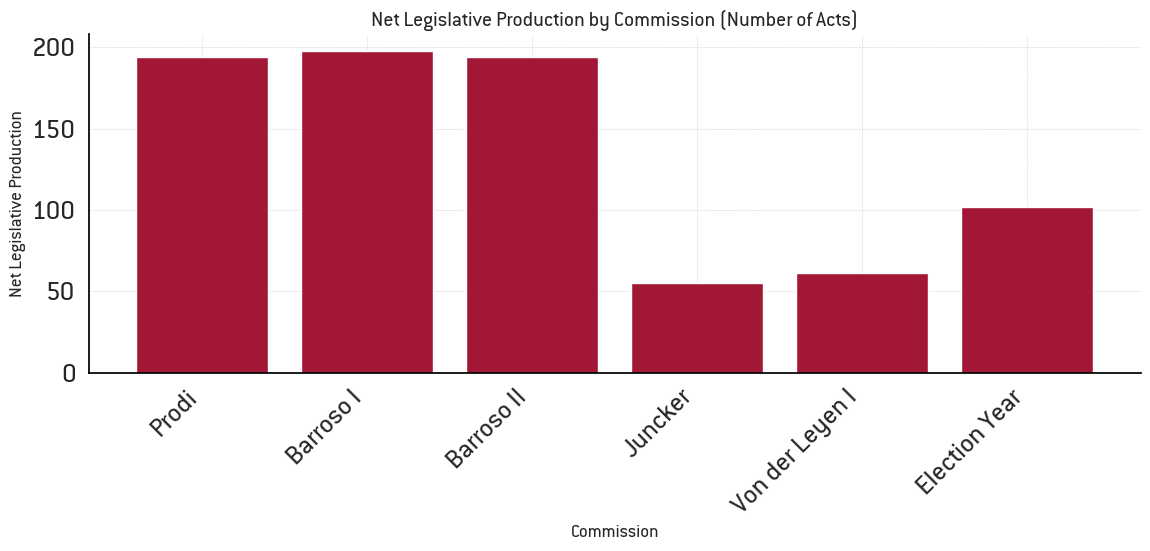

In [27]:
# Group by Commission and calculate the number of new legislation and sum of repeals
new_legislation_by_commission = proposals[proposals['Category'] == 'New Legislation'].groupby('Commission').size()
repeals_by_commission = proposals.groupby('Commission')['Repeal_Count'].sum()

# Create a DataFrame to hold the new legislation and repeals
net_legislative_production_commission_df = pd.DataFrame({
    'New Legislation': new_legislation_by_commission,
    'Total Repeals': repeals_by_commission
}).fillna(0)  # Fill missing values with 0

# Calculate net legislative production (New Legislation - Total Repeals)
net_legislative_production_commission_df['Net Legislative Production'] = net_legislative_production_commission_df['New Legislation'] - net_legislative_production_commission_df['Total Repeals']

# Display the DataFrame
print(net_legislative_production_commission_df)

# Plotting the grouped data by Commission
plt.figure(figsize=(12, 6))

# Plot the bar chart for net legislative production by Commission
plt.bar(net_legislative_production_commission_df.index, net_legislative_production_commission_df['Net Legislative Production'])

# Customize the plot
plt.title('Net Legislative Production by Commission (Number of Acts)', fontsize=16)
plt.xlabel('Commission', fontsize=14)
plt.ylabel('Net Legislative Production', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')  # Add grid lines only to the y-axis for better readability

# Show the plot
plt.tight_layout()
plt.show()


In [28]:

# Initialize a dictionary to store the results
shares = {}

# Calculate shares for each period
for period, (start_year, end_year) in periods.items():
    # Filter data for the specific period
    period_data = proposals[(proposals['Year'] >= start_year) & (proposals['Year'] <= end_year)]
    
    # Count the occurrences of 'Proposal for a regulation' and 'Proposal for a directive'
    regulation_count = period_data[period_data['Form'] == 'Proposal for a regulation'].shape[0]
    directive_count = period_data[period_data['Form'] == 'Proposal for a directive'].shape[0]
    
    # Count the occurrences of other forms
    other_count = period_data[~period_data['Form'].isin(['Proposal for a regulation', 'Proposal for a directive'])].shape[0]
    
    # Calculate the total number of proposals in this period
    total_count = regulation_count + directive_count + other_count
    
    # Calculate shares
    if total_count > 0:
        regulation_share = regulation_count / total_count * 100
        directive_share = directive_count / total_count * 100
        other_share = other_count / total_count * 100
    else:
        regulation_share = 0
        directive_share = 0
        other_share = 0
    
    # Store the results
    shares[period] = {
        'Regulation Share (%)': regulation_share,
        'Directive Share (%)': directive_share,
        'Other Share (%)': other_share
    }

# Convert the results into a DataFrame for better visualization
shares_df = pd.DataFrame(shares).T

# Display the DataFrame
print(shares_df)

                 Regulation Share (%)  Directive Share (%)  Other Share (%)
Prodi                       39.037433            43.850267        17.112299
Barroso I                   42.396313            43.548387        14.055300
Barroso II                  66.129032            26.209677         7.661290
Juncker                     73.544974            20.634921         5.820106
von der Leyen I             67.285383            24.129930         8.584687


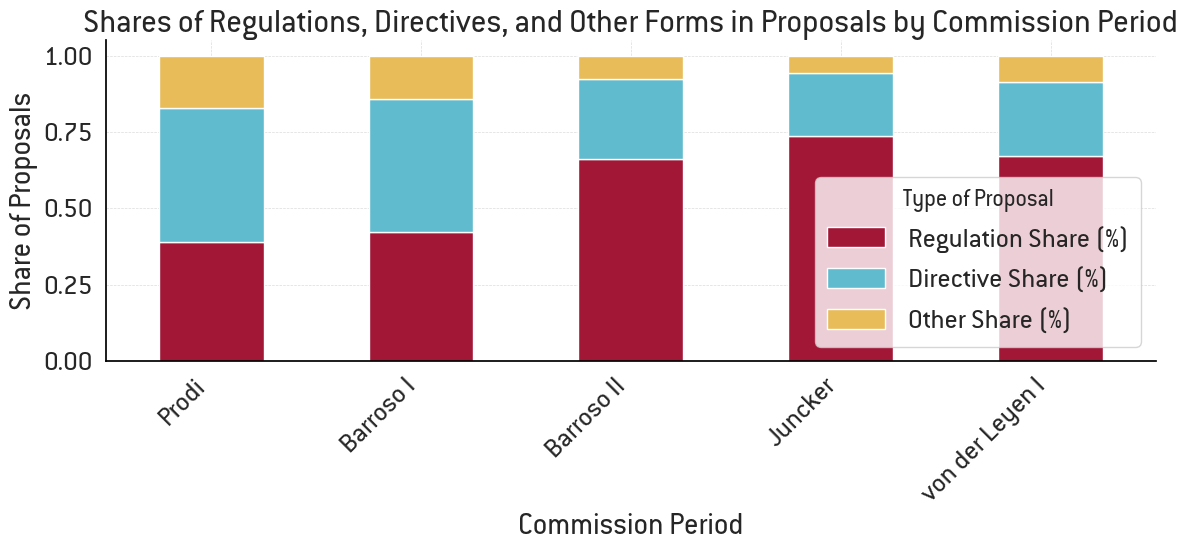

In [29]:
# Convert percentage shares to proportions (0-1 scale)
shares_proportions = shares_df.div(100)

# Plot the data as a stacked bar chart
shares_proportions.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
plt.xlabel('Commission Period')
plt.ylabel('Share of Proposals')
plt.title('Shares of Regulations, Directives, and Other Forms in Proposals by Commission Period')
plt.legend(title='Type of Proposal')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


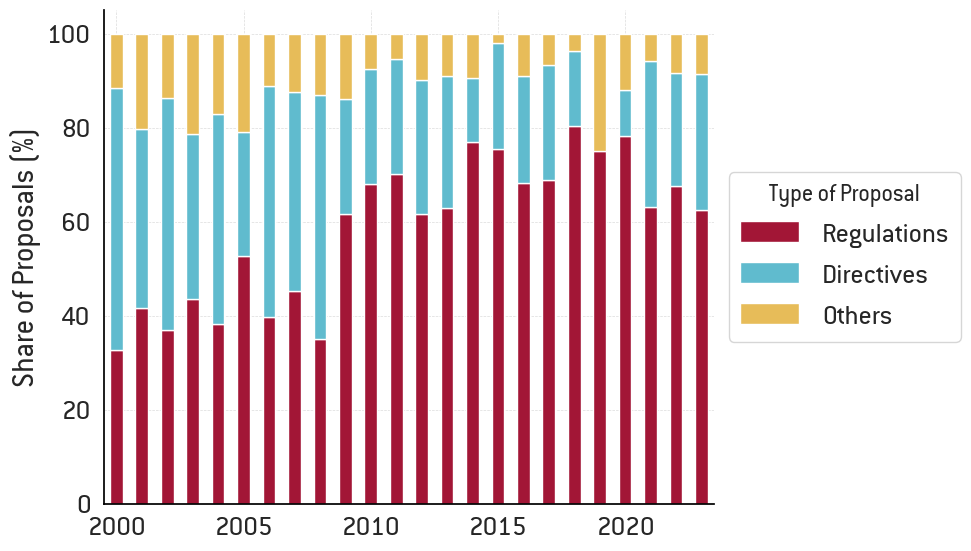

In [30]:
# Assuming `yearly_proposals` is already calculated and represents the total number of proposals for each year
yearly_proposals = proposals.groupby('Year').size()

# Calculate number of regulations, directives, and others for each year
regulation_counts = proposals[proposals['Form'] == 'Proposal for a regulation'].groupby('Year').size()
directive_counts = proposals[proposals['Form'] == 'Proposal for a directive'].groupby('Year').size()
other_counts = proposals[~proposals['Form'].isin(['Proposal for a regulation', 'Proposal for a directive'])].groupby('Year').size()

# Calculate shares and convert to percentages
shares = pd.DataFrame({
    'Regulations': (regulation_counts / yearly_proposals) * 100,
    'Directives': (directive_counts / yearly_proposals) * 100,
    'Others': (other_counts / yearly_proposals) * 100
}).fillna(0)

# Plot the data
ax = shares.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize x-axis to show every 5 years and remove rotation
ax.set_xticks(range(0, len(shares.index), 5))
ax.set_xticklabels(shares.index[::5], rotation = 0)

# Move the legend to the right of the plot
plt.legend(title='Type of Proposal', loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels and title
plt.xlabel('')
plt.ylabel('Share of Proposals (%)')
plt.title('')

# Adjust layout to accommodate the legend on the right
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.show()


In [31]:
# Remove 'European Commission, ' from the Author column to keep only the Directorate-General names
proposals['Author'] = proposals['Author'].str.replace('European Commission, ', '')

# Display the unique authors to confirm the change
unique_authors = proposals['Author'].unique()
unique_authors[:50]  # Display first 20 for brevity

array(['Directorate-General for Justice and Consumers',
       'Directorate-General for Health and Food Safety',
       'Directorate-General for Environment',
       'Directorate-General for Maritime Affairs and Fisheries',
       'Directorate-General for Mobility and Transport',
       'Directorate-General for Migration and Home Affairs',
       'Legal service',
       'Directorate-General for Agriculture and Rural Development',
       'Directorate-General for Neighbourhood and Enlargement Negotiations',
       'Directorate-General for Employment, Social Affairs and Inclusion',
       'Directorate-General for Financial Stability, Financial Services and Capital Markets Union',
       'Directorate-General for Internal Market, Industry, Entrepreneurship and SMEs',
       'Directorate-General for Economic and Financial Affairs',
       'Eurostat', 'Directorate-General for Trade',
       'Directorate-General for Research and Innovation',
       'Directorate-General for Budget',
       'Dir

In [32]:
# Full mapping dictionary to convert full names to their corresponding DG codes
dg_mapping = {
    'Directorate-General for Justice and Consumers': 'DG JUST',
    'Directorate-General for Health and Food Safety': 'DG SANTE',
    'Directorate-General for Environment': 'DG ENV',
    'Directorate-General for Maritime Affairs and Fisheries': 'DG MARE',
    'Directorate-General for Mobility and Transport': 'DG MOVE',
    'Directorate-General for Migration and Home Affairs': 'DG HOME',
    'Directorate-General for Agriculture and Rural Development': 'DG AGRI',
    'Directorate-General for Neighbourhood and Enlargement Negotiations': 'DG NEAR',
    'Directorate-General for Employment, Social Affairs and Inclusion': 'DG EMPL',
    'Directorate-General for Financial Stability, Financial Services and Capital Markets Union': 'DG FISMA',
    'Directorate-General for Internal Market, Industry, Entrepreneurship and SMEs': 'DG GROW',
    'Directorate-General for Economic and Financial Affairs': 'DG ECFIN',
    'Directorate-General for Trade': 'DG TRADE',
    'Directorate-General for Research and Innovation': 'DG RTD',
    'Directorate-General for Budget': 'DG BUDG',
    'Directorate-General for Taxation and Customs Union': 'DG TAXUD',
    'European Anti-Fraud Office': 'OLAF',
    'Directorate-General for Defence Industry and Space': 'DG DEFIS',
    'Directorate-General for Communications Networks, Content and Technology': 'DG CNECT',
    'Directorate-General for European Civil Protection and Humanitarian Aid Operations (ECHO)': 'DG ECHO',
    'Directorate-General for Energy': 'DG ENER',
    'Directorate-General for Climate Action': 'DG CLIMA',
    'Directorate-General for Digital Services': 'DG DIGIT',
    'Directorate-General for Regional and Urban Policy': 'DG REGIO',
    'Directorate-General for Human Resources and Security': 'DG HR',
    'Directorate-General for Education, Youth, Sport and Culture': 'DG EAC',
    'Directorate-General for Competition': 'DG COMP',
    'Directorate-General for International Cooperation and Development': 'DG DEVCO'
}

# Replace the full names in the 'Author' column using the mapping dictionary
proposals['Author'] = proposals['Author'].replace(dg_mapping)

# Display the unique authors to confirm the change
unique_authors = proposals['Author'].unique()
unique_authors[:50]  # Display first 20 for brevity


array(['DG JUST', 'DG SANTE', 'DG ENV', 'DG MARE', 'DG MOVE', 'DG HOME',
       'Legal service', 'DG AGRI', 'DG NEAR', 'DG EMPL', 'DG FISMA',
       'DG GROW', 'DG ECFIN', 'Eurostat', 'DG TRADE', 'DG RTD', 'DG BUDG',
       'DG TAXUD', 'OLAF', 'DG DEFIS', 'DG CNECT', 'DG ECHO', 'DG ENER',
       'DG CLIMA', 'DG DIGIT', 'DG REGIO', 'Secretariat-General', 'DG HR',
       'DG EAC', 'DG COMP', 'DG DEVCO',
       'Service for Foreign Policy Instruments', 'European Commission'],
      dtype=object)

In [33]:
import pandas as pd

# Assuming 'proposals' is your DataFrame with the filtered data

# Step 1: Filter for Juncker and Von der Leyen I Commissions
filtered_proposals = proposals[proposals['Commission'].isin(['Juncker', 'Von der Leyen I'])]

# Group by Author (DG) and Commission, then count occurrences
dg_counts = filtered_proposals.groupby(['Author', 'Commission']).size().unstack(fill_value=0)

# Step 2: Combine DG FISMA and DG GROW counts
if 'DG FISMA' in dg_counts.index and 'DG GROW' in dg_counts.index:
    dg_counts.loc['DG FISMA + DG GROW'] = dg_counts.loc['DG FISMA'] + dg_counts.loc['DG GROW']
    dg_counts = dg_counts.drop(['DG FISMA', 'DG GROW'])

# Ensure columns are not treated as categorical
dg_counts.columns = dg_counts.columns.astype(str)

# Calculate the total proposals in each Commission
total_proposals_juncker = dg_counts['Juncker'].sum()
total_proposals_von_der_leyen = dg_counts['Von der Leyen I'].sum()

# Calculate the percentage for each DG
dg_counts['% of proposals in Juncker'] = (dg_counts['Juncker'] / total_proposals_juncker * 100).round(1)
dg_counts['% of proposals in Von der Leyen I'] = (dg_counts['Von der Leyen I'] / total_proposals_von_der_leyen * 100).round(1)

# Rank DGs by the number of proposals in Juncker Commission
dg_counts['Rank in Juncker'] = dg_counts['Juncker'].rank(ascending=False, method='min').astype(int)

# Create the final table
dg_summary_table = dg_counts[['Von der Leyen I', '% of proposals in Von der Leyen I', 'Juncker', '% of proposals in Juncker']].reset_index()

# Rename columns to match the desired table format
dg_summary_table.columns = ['DG','Proposals in Von der Leyen I', '% of Von der Leyen I proposals', 'Proposals in Juncker', '% of proposals in Juncker']

# Sort the table by 'Rank in Von der Leyen I'
dg_summary_table = dg_summary_table.sort_values(by='Proposals in Von der Leyen I', ascending=False).reset_index()

# Display the final sorted table
dg_summary_table


,index,DG,Proposals in Von der Leyen I,% of Von der Leyen I proposals,Proposals in Juncker,% of proposals in Juncker
0,31,DG FISMA + DG GROW,87,20.2,64,16.9
1,18,DG MOVE,48,11.1,34,9.0
2,16,DG JUST,38,8.8,24,6.3
3,14,DG HOME,35,8.1,47,12.4
4,22,DG SANTE,31,7.2,5,1.3
5,13,DG ENV,27,6.3,13,3.4
6,17,DG MARE,17,3.9,17,4.5
7,3,DG CNECT,16,3.7,20,5.3
8,2,DG CLIMA,14,3.2,7,1.9
9,9,DG ECFIN,14,3.2,11,2.9


In [34]:
# Step 1: Filter the proposals DataFrame to include only the specified Commissions
filtered_proposals = proposals[proposals['Commission'].isin(['Juncker', 'Von der Leyen I'])]

# Step 2: Group by Commission and Author (Directorate-General) and count the occurrences
dg_counts = filtered_proposals.groupby(['Author', 'Commission']).size().unstack(fill_value=0)

# Step 3: Combine DG FISMA and DG GROW counts
# Check if both 'DG FISMA' and 'DG GROW' exist in the index
if 'DG FISMA' in dg_counts.index and 'DG GROW' in dg_counts.index:
    # Sum the counts for DG FISMA and DG GROW
    dg_counts.loc['DG FISMA + DG GROW'] = dg_counts.loc['DG FISMA'] + dg_counts.loc['DG GROW']
    
    # Drop the individual DG FISMA and DG GROW rows after summing
    dg_counts = dg_counts.drop(['DG FISMA', 'DG GROW'])

# Display the result
dg_counts


Commission,Prodi,Barroso I,Barroso II,Juncker,Von der Leyen I,Election Year
Author,,,,,,
DG AGRI,0,0,0,12,9,0
DG BUDG,0,0,0,2,5,0
DG CLIMA,0,0,0,7,14,0
DG CNECT,0,0,0,20,16,0
DG COMP,0,0,0,1,1,0
DG DEFIS,0,0,0,0,4,0
DG DEVCO,0,0,0,2,1,0
DG DIGIT,0,0,0,0,2,0
DG EAC,0,0,0,7,2,0
